In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def create_environment(cities = ['A','B','C','D','E','F','G'],  
                       path = ['A', 'F', 'D', 'E'], 
                       eps = 0.0001):
    N =len(cities)
    def distance_matrix(cities, path):
        env = pd.DataFrame(data=np.ones((N,N)) * 10, columns=cities, index = cities)
        
        ## -1: disallowed passage
        for i in range(N):
            env.loc[cities[i], cities[i]] = -1

        for i in range(len(path)-1):
            env.loc[path[i], path[i+1]] = 1
            env.loc[path[i+1], path[i]] = 1

        return env

    def pheremon_matrix(cities, eps = eps):
        N =len(cities)
        data = (np.ones((N,N))- np.eye(N)) /(N-1)
        return pd.DataFrame(data=data, columns=cities, index = cities)

    return distance_matrix(cities, path), pheremon_matrix(cities)

In [3]:
cities = ['A','B','C','D','E','F','G']
true_path = ['A', 'B','C','D', 'E']
env, phe = create_environment(cities = cities, path = true_path)

In [4]:
env

,A,B,C,D,E,F,G
A,-1.0,1.0,10.0,10.0,10.0,10.0,10.0
B,1.0,-1.0,1.0,10.0,10.0,10.0,10.0
C,10.0,1.0,-1.0,1.0,10.0,10.0,10.0
D,10.0,10.0,1.0,-1.0,1.0,10.0,10.0
E,10.0,10.0,10.0,1.0,-1.0,10.0,10.0
F,10.0,10.0,10.0,10.0,10.0,-1.0,10.0
G,10.0,10.0,10.0,10.0,10.0,10.0,-1.0


In [5]:
phe

,A,B,C,D,E,F,G
A,0.000000,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
B,0.166667,0.000000,0.166667,0.166667,0.166667,0.166667,0.166667
C,0.166667,0.166667,0.000000,0.166667,0.166667,0.166667,0.166667
D,0.166667,0.166667,0.166667,0.000000,0.166667,0.166667,0.166667
E,0.166667,0.166667,0.166667,0.166667,0.000000,0.166667,0.166667
F,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.166667
G,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000


In [6]:
possible_cities = ['B','C']

In [7]:
distances = env.loc['A'][possible_cities]
distances

B     1.0
C    10.0
Name: A, dtype: float64

In [8]:
pheremons = phe.loc['A'][possible_cities]
pheremons

B    0.166667
C    0.166667
Name: A, dtype: float64

In [9]:
preferences = pheremons/distances
probabilities = preferences/preferences.sum()
probabilities

B    0.909091
C    0.090909
Name: A, dtype: float64

In [10]:
class ant():
    def __init__(self, env, phe, 
                 start = 'A', end = 'E',
                alpha = 1, beta = 1):
        
        self.env, self.phe  = env, phe
        
        self.alpha, self.beta = alpha, beta
        self.cities = list(self.env.columns)
        self.current_city = start
        self.target_city = end
        
        self.route = [self.current_city]
        
        self.possible_cities = self.cities.copy()
        self.possible_cities.remove(self.current_city)
    
    def move(self):
        """
        Move one step
        """
        if self.current_city == self.target_city:
            return
        
        distances = self.env.loc[self.current_city][self.possible_cities]
        pheremons = self.phe.loc[self.current_city][self.possible_cities]
        
        preferences = pheremons**self.alpha/distances**self.beta
        probabilities = preferences/preferences.sum()
        #print(probabilities)
        
        self.current_city = np.random.choice(a = probabilities.index, 
                                             size=1, 
                                             p = probabilities.values)[0]
        
        self.route.append(self.current_city) 
        self.possible_cities.remove(self.current_city)
        
    def go(self):
        """
        Bulid route/path
        """
        for i in range(len(self.cities)):
            self.move()

    def deposit(self):
        return self.route
        
    def cost(self):
        result = 0
        for i in range(len(self.route)-1):
            result += self.env.loc[self.route[i], self.route[i+1]]
        return result

In [11]:
class antcolony():
    def __init__(self,
                 cities = ['A','B','C','D','E','F','G'],
                 true_path = ['A', 'B','C','D', 'E']):
        
        self.cities = cities
        self.true_path = true_path
        self.start, self.end = true_path[0], true_path[-1]
        
        self.env, self.phe = create_environment(cities = cities, path = true_path)
        
        self.true_path_ratio = []

    def evaporation(self, decay = 0.05):
        # Evaporation of Pheromon
        self.phe = self.phe * (1 - decay)
        
    def deposit(self, route, delta = 1):
        for i,j in zip(route[:-1], route[1:]):
            self.phe.loc[i, j] +=  delta/self.env.loc[i, j]
        
    def run(self, K = 10, time = 20):
        # in each time step
        for t in range(time):
            # K ants exist in the colony
            self.colony = [ant(env = self.env, phe = self.phe, 
                          start= self.start,end =  self.end) 
                      for k in range(K)]

            # distributed and paralel moves of K ants
            for k in range(K):
                self.colony[k].go()   

            # after independent moves, ants deposit pheremon
            for k in range(K):
                path = self.colony[k].deposit()
                self.deposit(route = path)
                
            self.evaporation()
            
            self.true_path_ratio.append(np.mean([a.route == true_path for a in self.colony]))

In [12]:
swarm = antcolony()
swarm.run(K = 10, time = 5)

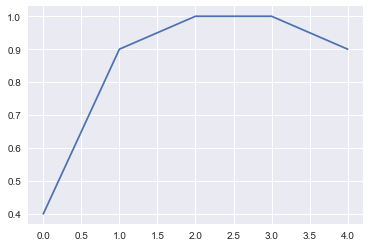

In [13]:
plt.plot(swarm.true_path_ratio)
plt.show()

In [14]:
swarm.phe
#'A', 'B','C','D', 'E'

,A,B,C,D,E,F,G
A,0.000000,43.110585,0.128963,0.128963,0.128963,0.128963,0.128963
B,0.128963,0.000000,39.200955,0.206342,0.206342,0.206342,0.287792
C,0.128963,0.128963,0.000000,38.250955,0.128963,0.223963,0.283720
D,0.128963,0.128963,0.902744,0.000000,38.467900,0.283720,0.128963
E,0.128963,0.128963,0.128963,0.128963,0.000000,0.128963,0.128963
F,0.128963,0.128963,0.128963,0.223963,0.361098,0.000000,0.128963
G,0.128963,0.128963,0.206342,0.210414,0.283720,0.128963,0.000000


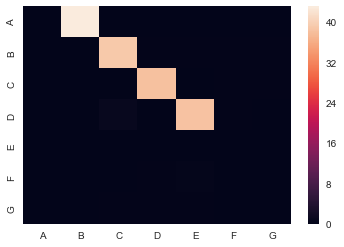

In [15]:
sns.heatmap(swarm.phe)
plt.show()

# Any graph

In [16]:
N = 100
path_len = 10
cities = ['A'+str(i) for i in range(N)]
true_path = ['A'+str(i) for i in np.random.choice(N, size=path_len,replace=False)]

start, end = true_path[0], true_path[-1]

print("cities:\n", cities)
print("\ntrue_path:\n", true_path)
print("\nstart, end:\n", start, end )

cities:
 ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99']

true_path:
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16']

start, end:
 A47 A16


In [17]:
swarm = antcolony(cities = cities, true_path =true_path)
swarm.run(K = 20, time = 40)

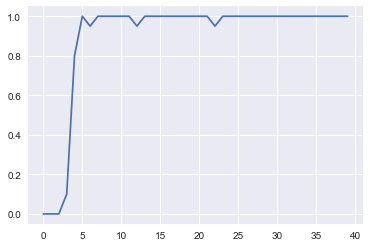

In [18]:
plt.plot(swarm.true_path_ratio)
plt.show()

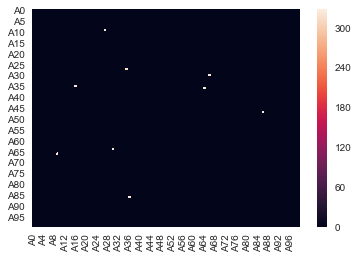

In [19]:
sns.heatmap(swarm.phe)
plt.show()

In [20]:
true_path

['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16']

In [21]:
i, j = np.where(swarm.phe > 50)

In [22]:
i

array([ 9, 27, 30, 35, 36, 47, 64, 66, 86])

In [23]:
j

array([27, 35, 66, 16, 64, 86, 30,  9, 36])

In [24]:
[a.route for a in swarm.colony]

[['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 'A16'],
 ['A47', 'A86', 'A36', 'A64', 'A30', 'A66', 'A9', 'A27', 'A35', 

## Longer path

In [25]:
N = 100
path_len = 70
cities = ['A'+str(i) for i in range(N)]
true_path = ['A'+str(i) for i in np.random.choice(N, size=path_len,replace=False)]

start, end = true_path[0], true_path[-1]

print("cities:\n", cities)
print("\ntrue_path:\n", true_path)
print("\nstart, end:\n", start, end )

cities:
 ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99']

true_path:
 ['A82', 'A18', 'A96', 'A66', 'A46', 'A30', 'A97', 'A45', 'A94', 'A29', 'A14', 'A47', 'A13', 'A56', 'A21', 'A64', 'A99', 'A68', 'A48', 'A2', 'A12', 'A74', 'A67', 'A55', 'A50', 'A78', 'A52', 'A95', 'A20', 'A75', 'A83', 'A65', 'A40', 'A77', 'A72', 'A70', 'A41', 'A35', 'A22', 'A36', 'A25', 

In [26]:
swarm = antcolony(cities = cities, true_path =true_path)
swarm.run(K = 50, time = 40)

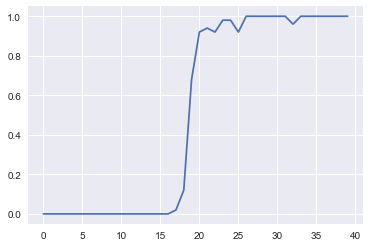

In [27]:
plt.plot(swarm.true_path_ratio)
plt.show()

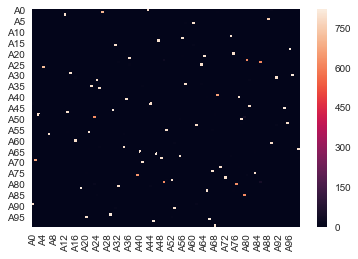

In [28]:
sns.heatmap(swarm.phe)
plt.show()